In [8]:
FILE_NAME = 'inter_dataset.csv'

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime

from sklearn.preprocessing import MinMaxScaler

%load_ext tensorboard
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


In [9]:
# split dataset 80% train, 15% validation, 5% dev
def split_dataset(dataset):
    size = dataset.shape[0]
    train_size = size * 80 // 100
    test_size = size * 15 // 100
    
    return dataset[0:train_size, :], dataset[train_size:(train_size + test_size), :], dataset[(train_size + test_size):size, :]

def plot_series(time, series, lab, form='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], form, label=lab)
    plt.xlabel("Minuto")
    plt.ylabel("Preço")
    plt.grid(True)

def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, lb, window_size):
    windowed_dataset = []
    labels = []
    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:i])
        labels.append(lb[i - 1])
        
    return np.array(windowed_dataset), np.array(labels)

In [10]:
data = pd.read_csv(FILE_NAME, sep=',')
data = data[['open', 'high', 'low', 'close', 'dollar_close', 'volume', 'close']]
data.columns.values[6] = "y"
data.head()

,open,high,low,close,dollar_close,volume,y
0,18.3500,18.5500,18.3500,18.5300,4.0979,0,18.5300
1,18.5307,18.5874,18.4373,18.4607,4.0990,15063,18.4607
2,18.4500,18.4500,18.3400,18.3500,4.0997,13800,18.3500
3,18.3303,18.3759,18.2758,18.3203,4.0977,47357,18.3203
4,18.3506,18.3979,18.3378,18.3606,4.1002,28101,18.3606


In [11]:
dataset = data['y']
dataset.loc[dataset.shape[0]]= 0.0
dataset = dataset.iloc[1:]
data.iloc[:, -1] = dataset.values
dataset = data[:-1]

dataset_to_numpy = dataset.values
dataset.head()

,open,high,low,close,dollar_close,volume,y
0,18.3500,18.5500,18.3500,18.5300,4.0979,0,18.4607
1,18.5307,18.5874,18.4373,18.4607,4.0990,15063,18.3500
2,18.4500,18.4500,18.3400,18.3500,4.0997,13800,18.3203
3,18.3303,18.3759,18.2758,18.3203,4.0977,47357,18.3606
4,18.3506,18.3979,18.3378,18.3606,4.1002,28101,18.4500


# Split dataset

In [12]:
train_dataset, cross_validation_dataset, dev_dataset = split_dataset(dataset_to_numpy)

print("Dataset shape: {:s}".format(str(dataset_to_numpy.shape)))
print("Train dataset shape: {:s}".format(str(train_dataset.shape)))
print("Cross validation dataset shape: {:s}".format(str(cross_validation_dataset.shape)))
print("Dev dataset shape: {:s}".format(str(dev_dataset.shape)))

Dataset shape: (11241, 7)
Train dataset shape: (8992, 7)
Cross validation dataset shape: (1686, 7)
Dev dataset shape: (563, 7)


# Stock prices graph

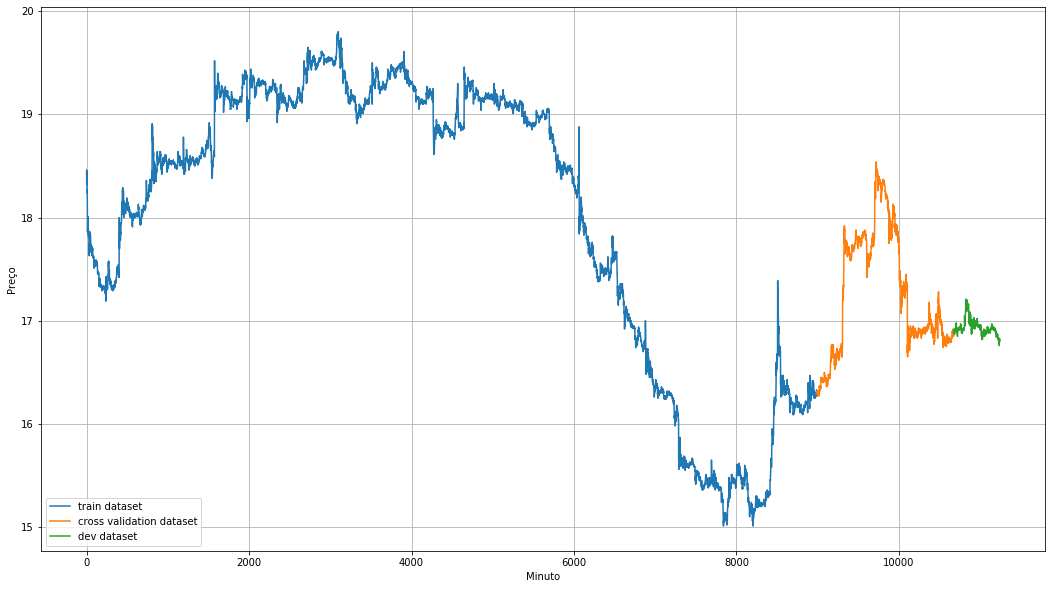

In [14]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(train_dataset.shape[0]), train_dataset[:, -1], "train dataset")
plot_series(np.arange(train_dataset.shape[0], (cross_validation_dataset.shape[0] + train_dataset.shape[0])), cross_validation_dataset[:, -1], "cross validation dataset")
plot_series(np.arange((cross_validation_dataset.shape[0] + train_dataset.shape[0]), (cross_validation_dataset.shape[0]+ train_dataset.shape[0] + dev_dataset.shape[0])), dev_dataset[:, -1], "dev dataset")
plt.legend(loc='lower left')

# Data normalization

In [17]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_dataset[:, 0:-1])

train_dataset_normalized = scaler.transform(train_dataset[:, 0:-1])
cross_validation_dataset_normalized = scaler.transform(cross_validation_dataset[:, 0:-1])
dev_dataset_normalized = scaler.transform(dev_dataset[:, 0:-1])

# Create window dataset

In [18]:
WINDOW_SIZE = 15
BATCH_SIZE = 64

windowed_dataset_train, labels_train = create_window_dataset(train_dataset[:, 0:-1], train_dataset[:, -1], WINDOW_SIZE)

windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
# for i in range(1,160):
#     if windowed_dataset_dev.shape[0] % i == 0:
#         dev_batch = i
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

In [19]:
TRAIN_STEP = math.ceil(windowed_dataset_train.shape[0] / BATCH_SIZE)
VALIDATION_STEP = math.ceil(windowed_dataset_validation.shape[0] / BATCH_SIZE)
DEV_STEP = windowed_dataset_dev.shape[0]

# Define model

In [67]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5,
                           strides=1,
                           padding="causal",
                           activation="relu",
                           input_shape=windowed_dataset_train.shape[-2:]),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(1e-4,
                                                             decay_steps=100000,
                                                             decay_rate=0.98,
                                                             staircase=False)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8),
              metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 64)            1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 13, 128)           82432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 128)           131584    
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0

# Train model

In [73]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_set,
                    epochs=1000,
                    steps_per_epoch=TRAIN_STEP,
                    validation_data=cross_validation_set,
                    validation_steps=VALIDATION_STEP,
                    verbose=1,
                    callbacks=[tensorboard_callback])

Train for 141 steps, validate for 27 steps
Epoch 1/1000
141/141 [==============================] - 3s 19ms/step - loss: 0.6423 - mae: 0.6312 - val_loss: 0.0180 - val_mae: 0.1000
Epoch 2/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.6385 - mae: 0.6259 - val_loss: 0.0231 - val_mae: 0.1218
Epoch 3/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.6344 - mae: 0.6225 - val_loss: 0.0260 - val_mae: 0.1328
Epoch 4/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.6435 - mae: 0.6243 - val_loss: 0.0180 - val_mae: 0.1002
Epoch 5/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.6335 - mae: 0.6234 - val_loss: 0.0208 - val_mae: 0.1121
Epoch 6/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.6513 - mae: 0.6294 - val_loss: 0.0157 - val_mae: 0.0889
Epoch 7/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.6188 - mae: 0.6200 - val_loss: 0.0150 - val_mae: 0.0852
Epoch 8/1000

Epoch 61/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5411 - mae: 0.5726 - val_loss: 0.0144 - val_mae: 0.0819
Epoch 62/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5570 - mae: 0.5850 - val_loss: 0.0186 - val_mae: 0.1024
Epoch 63/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5310 - mae: 0.5730 - val_loss: 0.0196 - val_mae: 0.1074
Epoch 64/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.5210 - mae: 0.5646 - val_loss: 0.0241 - val_mae: 0.1257
Epoch 65/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5339 - mae: 0.5741 - val_loss: 0.0113 - val_mae: 0.0653
Epoch 66/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5472 - mae: 0.5750 - val_loss: 0.0162 - val_mae: 0.0914
Epoch 67/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.5154 - mae: 0.5624 - val_loss: 0.0176 - val_mae: 0.0977
Epoch 68/1000
141/141 [=========================

141/141 [==============================] - 2s 14ms/step - loss: 0.4605 - mae: 0.5313 - val_loss: 0.0192 - val_mae: 0.1049
Epoch 122/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4536 - mae: 0.5267 - val_loss: 0.0170 - val_mae: 0.0951
Epoch 123/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4704 - mae: 0.5355 - val_loss: 0.0135 - val_mae: 0.0765
Epoch 124/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4645 - mae: 0.5297 - val_loss: 0.0221 - val_mae: 0.1174
Epoch 125/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4513 - mae: 0.5241 - val_loss: 0.0144 - val_mae: 0.0818
Epoch 126/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4492 - mae: 0.5234 - val_loss: 0.0151 - val_mae: 0.0850
Epoch 127/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.4522 - mae: 0.5265 - val_loss: 0.0129 - val_mae: 0.0739
Epoch 128/1000
141/141 [==============================] 

Epoch 181/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.4062 - mae: 0.4927 - val_loss: 0.0136 - val_mae: 0.0775
Epoch 182/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3784 - mae: 0.4796 - val_loss: 0.0159 - val_mae: 0.0900
Epoch 183/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.3940 - mae: 0.4859 - val_loss: 0.0130 - val_mae: 0.0739
Epoch 184/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3819 - mae: 0.4819 - val_loss: 0.0172 - val_mae: 0.0966
Epoch 185/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3864 - mae: 0.4838 - val_loss: 0.0145 - val_mae: 0.0825
Epoch 186/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3900 - mae: 0.4875 - val_loss: 0.0170 - val_mae: 0.0955
Epoch 187/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3866 - mae: 0.4859 - val_loss: 0.0121 - val_mae: 0.0687
Epoch 188/1000
141/141 [=================

Epoch 241/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3347 - mae: 0.4479 - val_loss: 0.0130 - val_mae: 0.0741
Epoch 242/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3372 - mae: 0.4508 - val_loss: 0.0118 - val_mae: 0.0671
Epoch 243/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3304 - mae: 0.4498 - val_loss: 0.0126 - val_mae: 0.0714
Epoch 244/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3233 - mae: 0.4419 - val_loss: 0.0163 - val_mae: 0.0918
Epoch 245/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3366 - mae: 0.4505 - val_loss: 0.0136 - val_mae: 0.0775
Epoch 246/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.3247 - mae: 0.4436 - val_loss: 0.0145 - val_mae: 0.0824
Epoch 247/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.3354 - mae: 0.4469 - val_loss: 0.0136 - val_mae: 0.0776
Epoch 248/1000
141/141 [=================

Epoch 301/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2785 - mae: 0.4125 - val_loss: 0.0123 - val_mae: 0.0709
Epoch 302/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2858 - mae: 0.4160 - val_loss: 0.0143 - val_mae: 0.0825
Epoch 303/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2817 - mae: 0.4135 - val_loss: 0.0116 - val_mae: 0.0664
Epoch 304/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.2849 - mae: 0.4145 - val_loss: 0.0123 - val_mae: 0.0713
Epoch 305/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2780 - mae: 0.4114 - val_loss: 0.0119 - val_mae: 0.0684
Epoch 306/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2771 - mae: 0.4086 - val_loss: 0.0132 - val_mae: 0.0766
Epoch 307/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2826 - mae: 0.4123 - val_loss: 0.0121 - val_mae: 0.0698
Epoch 308/1000
141/141 [=================

Epoch 361/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2387 - mae: 0.3781 - val_loss: 0.0125 - val_mae: 0.0722
Epoch 362/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2464 - mae: 0.3827 - val_loss: 0.0129 - val_mae: 0.0751
Epoch 363/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2438 - mae: 0.3815 - val_loss: 0.0119 - val_mae: 0.0690
Epoch 364/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.2511 - mae: 0.3890 - val_loss: 0.0123 - val_mae: 0.0712
Epoch 365/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2443 - mae: 0.3846 - val_loss: 0.0128 - val_mae: 0.0746
Epoch 366/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.2426 - mae: 0.3797 - val_loss: 0.0124 - val_mae: 0.0722
Epoch 367/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2372 - mae: 0.3738 - val_loss: 0.0122 - val_mae: 0.0707
Epoch 368/1000
141/141 [=================

Epoch 421/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2053 - mae: 0.3533 - val_loss: 0.0134 - val_mae: 0.0779
Epoch 422/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2159 - mae: 0.3577 - val_loss: 0.0125 - val_mae: 0.0732
Epoch 423/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2090 - mae: 0.3553 - val_loss: 0.0136 - val_mae: 0.0785
Epoch 424/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2046 - mae: 0.3473 - val_loss: 0.0137 - val_mae: 0.0793
Epoch 425/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2002 - mae: 0.3470 - val_loss: 0.0133 - val_mae: 0.0770
Epoch 426/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1984 - mae: 0.3428 - val_loss: 0.0127 - val_mae: 0.0742
Epoch 427/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.2109 - mae: 0.3525 - val_loss: 0.0132 - val_mae: 0.0765
Epoch 428/1000
141/141 [=================

Epoch 481/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1824 - mae: 0.3285 - val_loss: 0.0134 - val_mae: 0.0784
Epoch 482/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1813 - mae: 0.3258 - val_loss: 0.0134 - val_mae: 0.0782
Epoch 483/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1775 - mae: 0.3273 - val_loss: 0.0158 - val_mae: 0.0909
Epoch 484/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1779 - mae: 0.3256 - val_loss: 0.0137 - val_mae: 0.0798
Epoch 485/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1810 - mae: 0.3263 - val_loss: 0.0135 - val_mae: 0.0787
Epoch 486/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1822 - mae: 0.3279 - val_loss: 0.0143 - val_mae: 0.0833
Epoch 487/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1776 - mae: 0.3247 - val_loss: 0.0130 - val_mae: 0.0758
Epoch 488/1000
141/141 [=================

Epoch 541/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1588 - mae: 0.3070 - val_loss: 0.0151 - val_mae: 0.0872
Epoch 542/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1601 - mae: 0.3084 - val_loss: 0.0146 - val_mae: 0.0854
Epoch 543/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1597 - mae: 0.3070 - val_loss: 0.0147 - val_mae: 0.0853
Epoch 544/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1605 - mae: 0.3074 - val_loss: 0.0148 - val_mae: 0.0856
Epoch 545/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1524 - mae: 0.3008 - val_loss: 0.0141 - val_mae: 0.0827
Epoch 546/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1600 - mae: 0.3057 - val_loss: 0.0156 - val_mae: 0.0894
Epoch 547/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1564 - mae: 0.3042 - val_loss: 0.0146 - val_mae: 0.0853
Epoch 548/1000
141/141 [=================

Epoch 601/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1468 - mae: 0.2924 - val_loss: 0.0157 - val_mae: 0.0898
Epoch 602/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1386 - mae: 0.2851 - val_loss: 0.0152 - val_mae: 0.0873
Epoch 603/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1401 - mae: 0.2868 - val_loss: 0.0142 - val_mae: 0.0835
Epoch 604/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1442 - mae: 0.2897 - val_loss: 0.0150 - val_mae: 0.0867
Epoch 605/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1355 - mae: 0.2844 - val_loss: 0.0141 - val_mae: 0.0828
Epoch 606/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1400 - mae: 0.2889 - val_loss: 0.0148 - val_mae: 0.0858
Epoch 607/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1406 - mae: 0.2861 - val_loss: 0.0148 - val_mae: 0.0856
Epoch 608/1000
141/141 [=================

Epoch 661/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1277 - mae: 0.2733 - val_loss: 0.0137 - val_mae: 0.0802
Epoch 662/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1244 - mae: 0.2710 - val_loss: 0.0137 - val_mae: 0.0803
Epoch 663/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1265 - mae: 0.2728 - val_loss: 0.0137 - val_mae: 0.0803
Epoch 664/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1251 - mae: 0.2718 - val_loss: 0.0137 - val_mae: 0.0802
Epoch 665/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1260 - mae: 0.2720 - val_loss: 0.0142 - val_mae: 0.0820
Epoch 666/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1226 - mae: 0.2704 - val_loss: 0.0139 - val_mae: 0.0808
Epoch 667/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1266 - mae: 0.2738 - val_loss: 0.0138 - val_mae: 0.0803
Epoch 668/1000
141/141 [=================

Epoch 721/1000
141/141 [==============================] - 2s 13ms/step - loss: 0.1180 - mae: 0.2640 - val_loss: 0.0145 - val_mae: 0.0829
Epoch 722/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1188 - mae: 0.2657 - val_loss: 0.0135 - val_mae: 0.0788
Epoch 723/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1217 - mae: 0.2676 - val_loss: 0.0135 - val_mae: 0.0785
Epoch 724/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1205 - mae: 0.2677 - val_loss: 0.0143 - val_mae: 0.0825
Epoch 725/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1187 - mae: 0.2658 - val_loss: 0.0135 - val_mae: 0.0782
Epoch 726/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1134 - mae: 0.2588 - val_loss: 0.0134 - val_mae: 0.0778
Epoch 727/1000
141/141 [==============================] - 2s 13ms/step - loss: 0.1189 - mae: 0.2658 - val_loss: 0.0133 - val_mae: 0.0775
Epoch 728/1000
141/141 [=================

Epoch 781/1000
141/141 [==============================] - 2s 16ms/step - loss: 0.1074 - mae: 0.2522 - val_loss: 0.0138 - val_mae: 0.0803
Epoch 782/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1077 - mae: 0.2552 - val_loss: 0.0129 - val_mae: 0.0756
Epoch 783/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1074 - mae: 0.2541 - val_loss: 0.0135 - val_mae: 0.0787
Epoch 784/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.1108 - mae: 0.2555 - val_loss: 0.0129 - val_mae: 0.0758
Epoch 785/1000
141/141 [==============================] - 2s 16ms/step - loss: 0.1092 - mae: 0.2549 - val_loss: 0.0137 - val_mae: 0.0793
Epoch 786/1000
141/141 [==============================] - 2s 17ms/step - loss: 0.1092 - mae: 0.2574 - val_loss: 0.0135 - val_mae: 0.0785
Epoch 787/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1109 - mae: 0.2548 - val_loss: 0.0140 - val_mae: 0.0811
Epoch 788/1000
141/141 [=================

Epoch 841/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1008 - mae: 0.2463 - val_loss: 0.0137 - val_mae: 0.0791
Epoch 842/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1023 - mae: 0.2482 - val_loss: 0.0130 - val_mae: 0.0758
Epoch 843/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1013 - mae: 0.2450 - val_loss: 0.0135 - val_mae: 0.0783
Epoch 844/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1021 - mae: 0.2473 - val_loss: 0.0130 - val_mae: 0.0754
Epoch 845/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0997 - mae: 0.2448 - val_loss: 0.0129 - val_mae: 0.0749
Epoch 846/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0994 - mae: 0.2421 - val_loss: 0.0130 - val_mae: 0.0757
Epoch 847/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.1013 - mae: 0.2462 - val_loss: 0.0131 - val_mae: 0.0761
Epoch 848/1000
141/141 [=================

141/141 [==============================] - 2s 14ms/step - loss: 0.0959 - mae: 0.2376 - val_loss: 0.0127 - val_mae: 0.0740
Epoch 901/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0964 - mae: 0.2397 - val_loss: 0.0124 - val_mae: 0.0722
Epoch 902/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0996 - mae: 0.2411 - val_loss: 0.0123 - val_mae: 0.0719
Epoch 903/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0930 - mae: 0.2361 - val_loss: 0.0132 - val_mae: 0.0769
Epoch 904/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0932 - mae: 0.2355 - val_loss: 0.0133 - val_mae: 0.0776
Epoch 905/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0966 - mae: 0.2413 - val_loss: 0.0126 - val_mae: 0.0732
Epoch 906/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0929 - mae: 0.2367 - val_loss: 0.0131 - val_mae: 0.0763
Epoch 907/1000
141/141 [==============================] 

Epoch 960/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0866 - mae: 0.2273 - val_loss: 0.0127 - val_mae: 0.0744
Epoch 961/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0902 - mae: 0.2320 - val_loss: 0.0123 - val_mae: 0.0718
Epoch 962/1000
141/141 [==============================] - 2s 15ms/step - loss: 0.0909 - mae: 0.2350 - val_loss: 0.0132 - val_mae: 0.0768
Epoch 963/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0891 - mae: 0.2322 - val_loss: 0.0118 - val_mae: 0.0689
Epoch 964/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0904 - mae: 0.2335 - val_loss: 0.0122 - val_mae: 0.0711
Epoch 965/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0887 - mae: 0.2292 - val_loss: 0.0126 - val_mae: 0.0734
Epoch 966/1000
141/141 [==============================] - 2s 14ms/step - loss: 0.0888 - mae: 0.2323 - val_loss: 0.0118 - val_mae: 0.0686
Epoch 967/1000
141/141 [=================

## Save model weights

In [79]:
model.save_weights('weights/inter_model_weights.ckpt')

## Load model weights

In [80]:
model.load_weights('weights/inter_model_weights.ckpt')

# Predictions

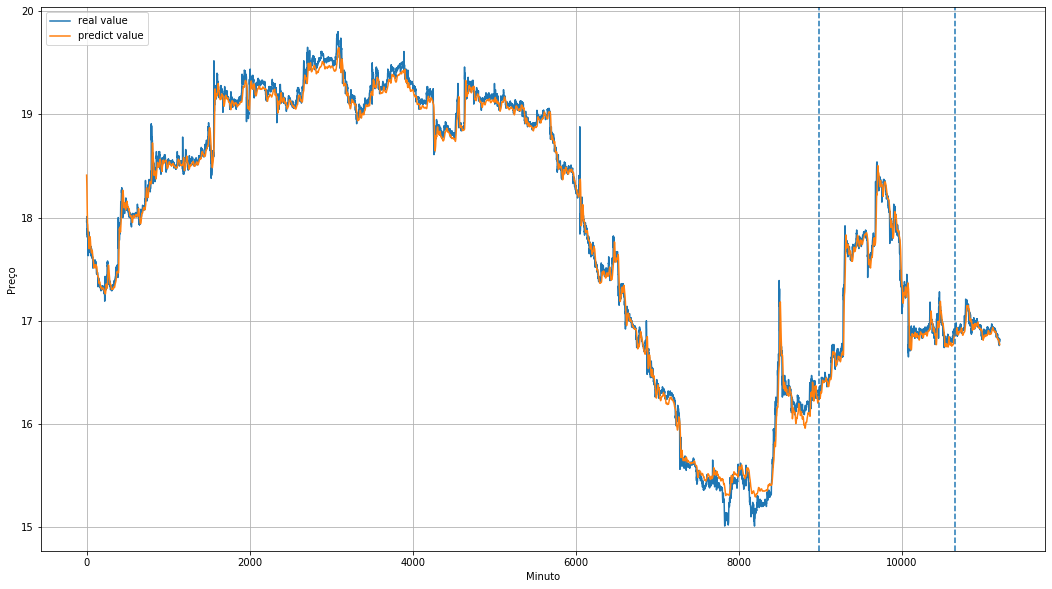

In [81]:
forecast_train = model.predict(unshuffled_train_set, steps=TRAIN_STEP)
forecast_validation = model.predict(cross_validation_set, steps=VALIDATION_STEP)
forecast_dev = model.predict(dev_set, steps=DEV_STEP)

total_forecast = np.concatenate((forecast_train[:,0], forecast_validation[:,0], forecast_dev[:,0]))
total_labels = np.concatenate((labels_train, labels_validation, labels_dev))

plt.figure(figsize=(18, 10))
plot_series(np.arange(total_labels.shape[0]), total_labels, "real value")
plot_series(np.arange(total_labels.shape[0]), total_forecast, "predict value")
xpositions = [labels_train.shape[0], (labels_train.shape[0] + labels_validation.shape[0])]
for xp in xpositions:
    plt.axvline(x=xp, linestyle='--')
plt.legend(loc='upper left')

## Predictions: Train data

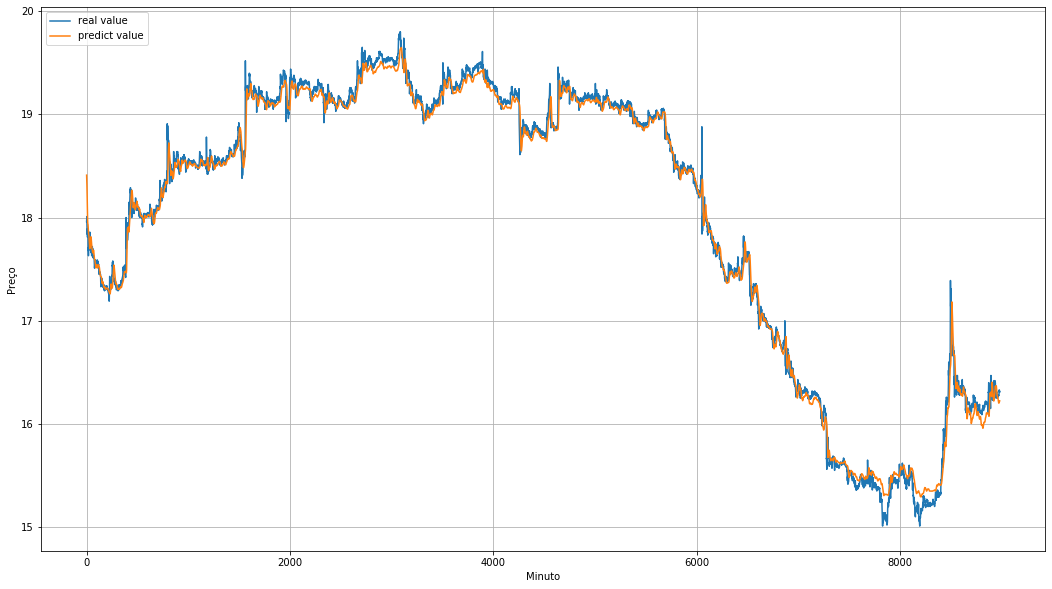

In [82]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_train.shape[0]), labels_train, "real value")
plot_series(np.arange(labels_train.shape[0]), forecast_train[:,0], "predict value")
plt.legend(loc='upper left')

## Predictions: Validation data

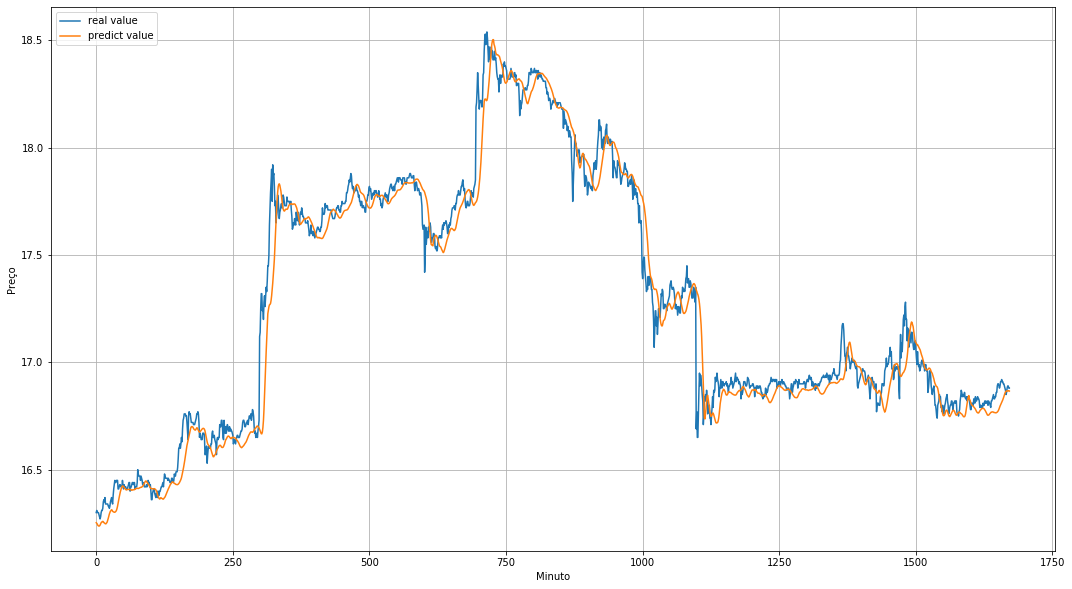

In [83]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_validation.shape[0]), labels_validation, "real value")
plot_series(np.arange(labels_validation.shape[0]), forecast_validation[:,0], "predict value")
plt.legend(loc='upper left')

## Predictions: Dev data

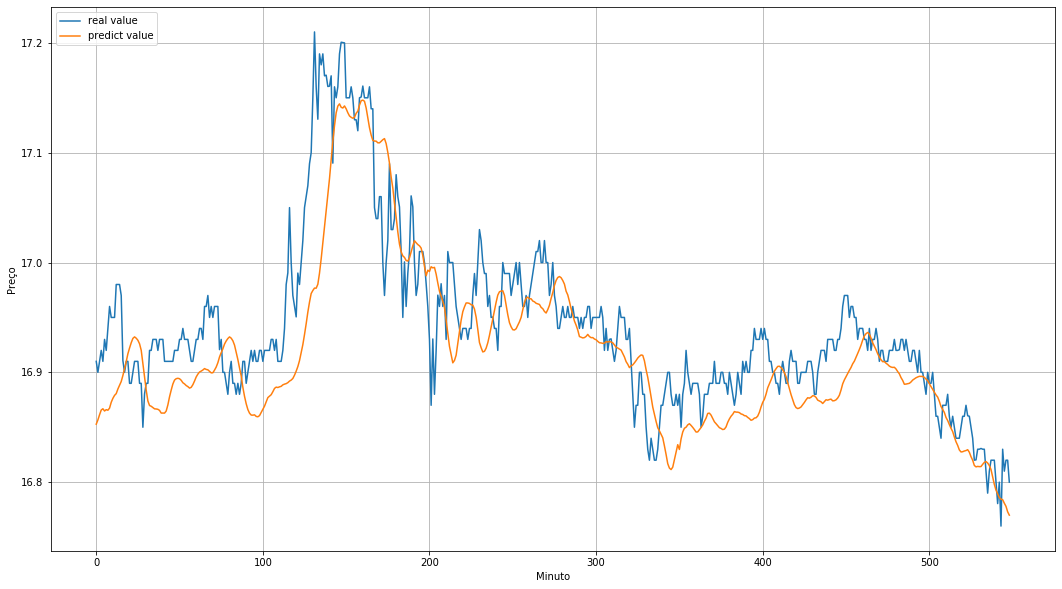

In [84]:
plt.figure(figsize=(18, 10))
plot_series(np.arange(labels_dev.shape[0]), labels_dev, "real value")
plot_series(np.arange(labels_dev.shape[0]), forecast_dev[:,0], "predict value")
plt.legend(loc='upper left')